In [320]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [63]:
import matplotlib
import matplotlib.pyplot as plt

In [2]:
SEED = 222
np.random.seed(SEED)

In [3]:
nb_data1=pd.read_csv('./output/node/nodesim1.csv',encoding='gbk')
nb_data2=pd.read_csv('./output/node/nodesim2.csv',encoding='gbk')
lp_data1=pd.read_csv('./output/path/lp1.csv',encoding='gbk')
lp_data2=pd.read_csv('./output/path/lp2.csv',encoding='gbk')
lsp_data1=pd.read_csv('./output/path/lsp1.csv',encoding='gbk')
lsp_data2=pd.read_csv('./output/path/lsp2.csv',encoding='gbk')
rwr_data1=pd.read_csv('./output/randomwalk/rwr1.csv',encoding='gbk')
rwr_data2=pd.read_csv('./output/randomwalk/rwr.csv',encoding='gbk')
rwrr_data1=pd.read_csv('./output/randomwalk/rwrr1.csv',encoding='gbk')
rwrr_data2=pd.read_csv('./output/randomwalk/rwrr.csv',encoding='gbk')

In [4]:
len(nb_data1)

380480

In [5]:
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline
def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    knn = KNeighborsClassifier()
    lr = LogisticRegression(penalty='l1')
    rf = RandomForestClassifier(n_estimators=10, random_state=SEED)
    xgb = XGBClassifier()
    models = {
              'knn': knn,
              'naive bayes': nb,
              'logistic': lr,
              'random forest': rf,
              'xgb': xgb,
              }
    return models

(Pred == Prob.apply(lambda p: 1*(p > 0.5))).sum() # 所以阈值为大于0.5

In [10]:
def train_predict(models):
    """Fit models in list on training set and return preds"""
    P = np.zeros((ytest.shape[0], len(models)))
    P = pd.DataFrame(P)  # probability dataframe
    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(xtrain, ytrain)
        P.iloc[:, i] = m.predict_proba(xtest)[:, 1]
        cols.append(name)
        print("done")
    P.columns = cols
    print("Done.\n")
    return P
def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    eval_df = pd.DataFrame(np.zeros((len(P.columns), 6)), columns = ['model', 'accuracy', 'precision', 'recall', 'f1', 'auc'])
    for i, m in enumerate(P.columns):
        auc = roc_auc_score(y, P.loc[:, m])
        pred = 1*(P.loc[:, m] > 0.5) # predict class
        accuracy = accuracy_score(y, pred)
        precision = precision_score(y, pred)
        recall = recall_score(y, pred)
        f1 = f1_score(y, pred)
        print("%-26s: %f, %f, %f, %f, %f" % (m, accuracy, precision, recall, f1, auc))
        eval_df.iloc[i, :] = [m, accuracy, precision, recall, f1, auc]
    return eval_df
    print("Done.\n")
def train_eval():
    models = get_models()
    P = train_predict(models)
    eval_df = score_models(P, ytest)
    return eval_df

In [7]:
col1=['CN','JC','AA','RA','PA','CS','LHN','HP','HD','SI']
col2=['CN_2','JC_2','AA_2','RA_2','PA_2','CS_2','LHN_2','HP_2','HD_2','SI_2']
nb11=np.mat(nb_data1.loc[:,col1])  
nb12=np.mat(nb_data1.loc[:,col2])
nb21=np.mat(nb_data2.loc[:,col1])
nb22=np.mat(nb_data2.loc[:,col2])
nb1= (nb11+nb12)/2.0    
nb2= (nb21+nb22)/2.0
cp1= (np.mat(nb_data1['CP'])+np.mat(nb_data1['CP_2']))/2.0    
cp2= (np.mat(nb_data2['CP'])+np.mat(nb_data2['CP_2']))/2.0
cp1=cp1.reshape(-1,1)    
cp2=cp2.reshape(-1,1)
lp1=np.mat(lp_data1['lp']+nb_data1['CN_2']).reshape(-1,1) 
lp2=np.mat(lp_data2['lp']+nb_data2['CN_2']).reshape(-1,1)
lsp1=np.mat(lsp_data1['LSP']).reshape(-1,1)
lsp2=np.mat(lsp_data2['LSP']).reshape(-1,1)
rwr1=np.mat(rwr_data1['RWR']).reshape(-1,1)  
rwr2=np.mat(rwr_data2['rwr']).reshape(-1,1)
rwrr1=np.mat(rwrr_data1['RWRR']).reshape(-1,1)    
rwrr2=np.mat(rwrr_data2['rwrr']).reshape(-1,1)
NLR1=np.column_stack((nb1,lp1,rwr1))
NLR2=np.column_stack((nb2,lp2,rwr2))

In [8]:
xtrain = nb1
xtest = nb2

ytrain=nb_data1['link'].values
ytest=nb_data2['link'].values

In [11]:
eval_df = train_eval()

Fitting models.
knn... done
xgb... done
logistic... done
random forest... done
naive bayes... done
Done.

Scoring models.
knn                       : 0.628124, 0.698651, 0.450611, 0.547864, 0.663138
xgb                       : 0.901374, 0.919547, 0.879715, 0.899190, 0.953005
logistic                  : 0.886252, 0.895609, 0.874425, 0.884890, 0.928593
random forest             : 0.891552, 0.897304, 0.884314, 0.890762, 0.939377
naive bayes               : 0.558723, 0.811743, 0.152908, 0.257341, 0.721241


### 0. Similarity is model itself

In [254]:
roc_auc_score(ytrain, lsp1), roc_auc_score(ytest, lsp2)

(0.040943794351595016, 0.042118092230221227)

In [257]:
col1=['CN','JC','AA','RA','PA','CS','LHN','HP','HD','SI', 'CP']
col2=['CN_2','JC_2','AA_2','RA_2','PA_2','CS_2','LHN_2','HP_2','HD_2','SI_2', 'CP_2']
cols = col1 + col2
for col in cols:
    print(col, roc_auc_score(ytrain, nb_data1[col]))

CN 0.698396529539
JC 0.691076123215
AA 0.784942740163
RA 0.792729689435
PA 0.462915156947
CS 0.770658462391
LHN 0.798340390788
HP 0.848538070877
HD 0.669949069606
SI 0.691076123215
CP 0.852059033174
CN_2 0.724988275221
JC_2 0.615119263927
AA_2 0.723936476968
RA_2 0.720570155912
PA_2 0.71658903797
CS_2 0.728639444751
LHN_2 0.513886708996
HP_2 0.935801396012
HD_2 0.600493820599
SI_2 0.615119263927
CP_2 0.954314130134


In [313]:
unknown_edges = edges2 - edges1
def unknown_unexist_data(data):
    unknown_data = list(filter(lambda x: (x[0], x[1]) in unknown_edges, np.array(data)))
    unknown_data = pd.DataFrame(unknown_data, columns=data.columns)
    unexist_data = data.loc[data['link'] == 0].iloc[:len(unknown_data), :]
    data = pd.concat([unknown_data, unexist_data], axis=0, ignore_index=True)
    return data

In [314]:
NB_data = unknown_unexist_data(nb_data1)

In [316]:
col1=['CN','JC','AA','RA','PA','CS','LHN','HP','HD','SI', 'CP']
col2=['CN_2','JC_2','AA_2','RA_2','PA_2','CS_2','LHN_2','HP_2','HD_2','SI_2', 'CP_2']
cols = col1 + col2
for col in col1:
    print(col, roc_auc_score(NB_data['link'], NB_data[col]+NB_data[col+'_2']))

CN 0.742974302293
JC 0.512453009032
AA 0.744044947481
RA 0.741758212158
PA 0.75331373231
CS 0.549390919881
LHN 0.274693620936
HP 0.6537393029
HD 0.505198838225
SI 0.511504978509
CP 0.72327184472


In [259]:
roc_auc_score(ytrain, lp1), roc_auc_score(ytrain, lsp1), roc_auc_score(ytrain, rwr1), roc_auc_score(ytrain, rwrr1)

(0.81842225910933797,
 0.040943794351595016,
 0.95987511278138071,
 0.96274882510576265)

In [319]:
LP = unknown_unexist_data(lp_data1)
print(roc_auc_score(LP['link'], LP['lp']))
LSP = unknown_unexist_data(lsp_data1)
print(roc_auc_score(LSP['link'], LSP['LSP']))
RWR = unknown_unexist_data(rwr_data1)
print(roc_auc_score(RWR['link'], RWR['RWR']))
RWRR = unknown_unexist_data(rwrr_data1)
print(roc_auc_score(RWRR['link'], RWRR['RWRR']))

0.870597501395
0.13580601576
0.876580409541
0.866812570686


### 1. Neighbor based similarities

In [16]:
# nb每一对特征
cols=['CN','JC','AA','RA','PA','CS','LHN','HP','HD','SI'] + ['CP']
ytrain = nb_data1['link'].values
ytest = nb_data2['link'].values
Eval = pd.DataFrame()
for col in cols:
    print(col)
    xtrain = (nb_data1[col] + nb_data1[col+'_2']).reshape(-1,1)
    xtest = (nb_data2[col] + nb_data2[col+'_2']).reshape(-1,1)
    eval_df = train_eval()
    Eval = Eval.append(pd.concat([pd.Series([col]*5, name='similarity'), eval_df], axis=1))

CN
Fitting models.
knn... done
xgb... done
logistic... done
random forest... done
naive bayes... done
Done.

Scoring models.
knn                       : 0.552205, 0.547048, 0.607003, 0.575468, 0.557549
xgb                       : 0.662874, 0.687756, 0.596613, 0.638951, 0.732001
logistic                  : 0.621621, 0.784347, 0.335482, 0.469955, 0.723205
random forest             : 0.620788, 0.670481, 0.475043, 0.556091, 0.678736
naive bayes               : 0.572470, 0.813377, 0.188096, 0.305536, 0.620423
JC
Fitting models.
knn... done
xgb... done
logistic... done
random forest... done
naive bayes... done
Done.

Scoring models.
knn                       : 0.687552, 0.681289, 0.704826, 0.692858, 0.717988
xgb                       : 0.764416, 0.731868, 0.834602, 0.779867, 0.814720
logistic                  : 0.610922, 0.657668, 0.462683, 0.543208, 0.724466
random forest             : 0.689960, 0.714497, 0.632762, 0.671150, 0.731043
naive bayes               : 0.564682, 0.674803, 0.249694,

In [21]:
Eval

,similarity,model,accuracy,precision,recall,f1,auc
0,CN,knn,0.552205,0.547048,0.607003,0.575468,0.557549
1,CN,xgb,0.662874,0.687756,0.596613,0.638951,0.732001
2,CN,logistic,0.621621,0.784347,0.335482,0.469955,0.723205
3,CN,random forest,0.620788,0.670481,0.475043,0.556091,0.678736
4,CN,naive bayes,0.572470,0.813377,0.188096,0.305536,0.620423
0,JC,knn,0.687552,0.681289,0.704826,0.692858,0.717988
1,JC,xgb,0.764416,0.731868,0.834602,0.779867,0.814720
2,JC,logistic,0.610922,0.657668,0.462683,0.543208,0.724466
3,JC,random forest,0.689960,0.714497,0.632762,0.671150,0.731043
4,JC,naive bayes,0.564682,0.674803,0.249694,0.364510,0.620812


In [22]:
Eval.to_csv('./output/modelresult2/eval_nb.csv', index=False)

In [321]:
Eval = pd.read_csv('./output/modelresult2/eval_nb.csv')
Eval.head()

,similarity,model,accuracy,precision,recall,f1,auc
0,CN,knn,0.552205,0.547048,0.607003,0.575468,0.557549
1,CN,xgb,0.662874,0.687756,0.596613,0.638951,0.732001
2,CN,logistic,0.621621,0.784347,0.335482,0.469955,0.723205
3,CN,random forest,0.620788,0.670481,0.475043,0.556091,0.678736
4,CN,naive bayes,0.572470,0.813377,0.188096,0.305536,0.620423


In [323]:
full_name = {
    'PA': 'Preferential Attachment','CN': 'Common Neighbors', 'CS': 'Salton', 'JC': 'Jaccard',
    'AA': 'Adamic-Adar', 'RA': 'Resource Allocation', 'SI': 'Sorence', 'LHN': 'Leicht-Holme-Newman',
    'HD': 'Hub Depressed Index', 'HP':'Hub Promoted Index', 'CP': 'Bidirectional Conditional Probability',
}

In [324]:
data = {}
for i in range(len(Eval)):
    e = Eval.iloc[i, :]
    data.setdefault(e[1], dict())
#     if e[0]=='SI':
#         e[0] = 'Sorence'
    e[0] = full_name[e[0]]
    data[e[1]][e[0]] = e[6]

/home/lcy/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [325]:
# xticks = ['PA','CN','CS','JC','AA','RA','Sorence','LHN','HD','HP','CP']
xticks = ['Preferential Attachment', 'Common Neighbors', 'Salton', 'Jaccard', 'Adamic-Adar', 'Resource Allocation',
         'Sorence', 'Leicht-Holme-Newman', 'Hub Depressed Index', 'Hub Promoted Index', 'Bidirectional Conditional Probability']
df = pd.DataFrame(data).loc[xticks]
df

,knn,logistic,naive bayes,random forest,xgb
Preferential Attachment,0.650740,0.716864,0.591307,0.635759,0.714989
Common Neighbors,0.557549,0.723205,0.620423,0.678736,0.732001
Salton,0.709012,0.815795,0.815564,0.718635,0.821670
Jaccard,0.717988,0.724466,0.620812,0.731043,0.814720
Adamic-Adar,0.595021,0.723776,0.602002,0.614917,0.745990
Resource Allocation,0.599354,0.722110,0.573509,0.628134,0.742956
Sorence,0.716581,0.729126,0.719561,0.726853,0.817130
Leicht-Holme-Newman,0.590081,0.793397,0.793397,0.602992,0.876443
Hub Depressed Index,0.697570,0.697365,0.565248,0.722239,0.807054
Hub Promoted Index,0.860649,0.905420,0.905420,0.879685,0.920201


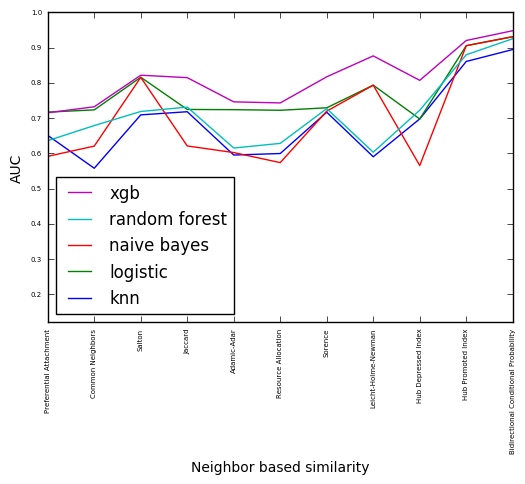

In [328]:
ax = plt.gca()
ax.set_xlabel('Neighbor based similarity')
ax.set_ylabel('AUC')
df.plot(ax=ax, xticks = range(11), legend='reverse', ylim=[0.12, 1.0], rot = 90, fontsize=5)
plt.savefig('./output/pics3/neighbors_based.jpg',dpi=600,bbox_inches='tight')
plt.savefig('./output/pics3/neighbors_based.eps',dpi=600,bbox_inches='tight')
plt.savefig('./output/pics3/neighbors_based.pdf',dpi=600,bbox_inches='tight')
plt.show()

### 2. Path based similarities

In [26]:
Eval = pd.DataFrame()
sim_data = {
    'lp': [lp1, lp2],
    'lsp': [lsp1, lsp2],
    'rwr': [rwr1, rwr2],
    'rwrr': [rwrr1, rwrr2]
}
for name, sim in sim_data.items():
    xtrain, xtest = sim
    eval_df = train_eval()
    Eval = Eval.append(pd.concat([pd.Series([name.upper()]*5, name='similarity'), eval_df], axis=1))

Fitting models.
knn... done
xgb... done
logistic... done
random forest... done
naive bayes... done
Done.

Scoring models.
knn                       : 0.901694, 0.905962, 0.896437, 0.901174, 0.936325
xgb                       : 0.912904, 0.928676, 0.894507, 0.911271, 0.961632
logistic                  : 0.837843, 0.968548, 0.698364, 0.811560, 0.961415
random forest             : 0.878061, 0.962076, 0.787151, 0.865867, 0.879532
naive bayes               : 0.802621, 0.971289, 0.623678, 0.759604, 0.961402
Fitting models.
knn... done
xgb... done
logistic... done
random forest... done
naive bayes... done
Done.

Scoring models.
knn                       : 0.723352, 0.702599, 0.774568, 0.736830, 0.770193
xgb                       : 0.771964, 0.735193, 0.850137, 0.788498, 0.826409
logistic                  : 0.627709, 0.788683, 0.348901, 0.483784, 0.815863
random forest             : 0.700751, 0.687115, 0.737191, 0.711273, 0.748715
naive bayes               : 0.576033, 0.817664, 0.195709, 0.315

In [27]:
Eval.to_csv('./output/modelresult2/eval_path.csv', index=False)

In [28]:
Eval

,similarity,model,accuracy,precision,recall,f1,auc
0,RWRR,knn,0.901694,0.905962,0.896437,0.901174,0.936325
1,RWRR,xgb,0.912904,0.928676,0.894507,0.911271,0.961632
2,RWRR,logistic,0.837843,0.968548,0.698364,0.811560,0.961415
3,RWRR,random forest,0.878061,0.962076,0.787151,0.865867,0.879532
4,RWRR,naive bayes,0.802621,0.971289,0.623678,0.759604,0.961402
0,LP,knn,0.723352,0.702599,0.774568,0.736830,0.770193
1,LP,xgb,0.771964,0.735193,0.850137,0.788498,0.826409
2,LP,logistic,0.627709,0.788683,0.348901,0.483784,0.815863
3,LP,random forest,0.700751,0.687115,0.737191,0.711273,0.748715
4,LP,naive bayes,0.576033,0.817664,0.195709,0.315825,0.645890


figure-path-based

In [329]:
Eval = pd.read_csv('./output/modelresult2/eval_path.csv')

In [330]:
full_name = {
    'LP': 'Local Path', 'LSP': 'Local Shortest Path', 
    'RWR': 'Random Walk with Restart', 'RWRR': 'Random Walk with Resource Redistribution',
}

In [335]:
data = {}
for i in range(len(Eval)):
    e = Eval.iloc[i, :]
    data.setdefault(e[1], dict())
#     e[0] = full_name[e[0]]
    e[0] = e[0]
    data[e[1]][e[0]] = e[6]

# xticks = ['Local Path', 'Local Shortest Path', 'Random Walk with Restart', 'Random Walk with Resource Redistribution']
xticks = ['LP', 'LSP', 'RWR', 'RWRR']
df = pd.DataFrame(data).loc[xticks]
df

/home/lcy/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,knn,logistic,naive bayes,random forest,xgb
LP,0.770193,0.815863,0.645890,0.748715,0.826409
LSP,0.939857,0.957882,0.957871,0.955815,0.957811
RWR,0.933818,0.958367,0.958367,0.921162,0.959260
RWRR,0.936325,0.961415,0.961402,0.879532,0.961632


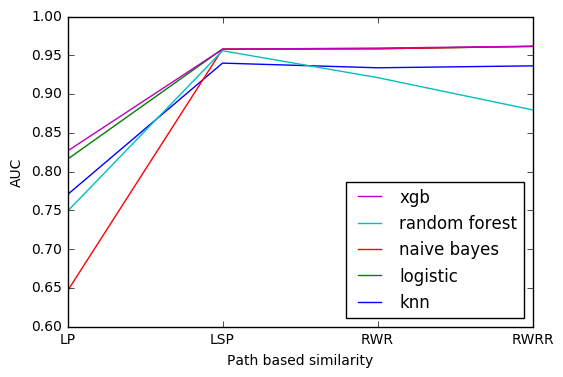

In [338]:
ax = plt.gca()
ax.set_xlabel('Path based similarity')
ax.set_ylabel('AUC')
df.plot(ax=ax, xticks = range(4), legend='reverse')
plt.savefig('./output/pics3/path_based2.jpg',dpi=600,bbox_inches='tight')
plt.savefig('./output/pics3/path_based2.eps',dpi=600,bbox_inches='tight')
plt.savefig('./output/pics3/path_based2.pdf',dpi=600,bbox_inches='tight')
plt.show()

### 3. RWR vs. RWRR

In [220]:
import re, os
rw_list = list(filter(lambda x : re.search('rwr.*\.csv', x) ,os.listdir('./output/randomwalk/')))
len(rw_list)

100

In [221]:
sorted(rw_list)

['rwr+1000.csv',
 'rwr+10000.csv',
 'rwr+11000.csv',
 'rwr+13000.csv',
 'rwr+15000.csv',
 'rwr+17000.csv',
 'rwr+19000.csv',
 'rwr+20000.csv',
 'rwr+21000.csv',
 'rwr+23000.csv',
 'rwr+2500.csv',
 'rwr+25000.csv',
 'rwr+27000.csv',
 'rwr+29000.csv',
 'rwr+3000.csv',
 'rwr+31000.csv',
 'rwr+33000.csv',
 'rwr+35000.csv',
 'rwr+37000.csv',
 'rwr+39000.csv',
 'rwr+40000.csv',
 'rwr+5000.csv',
 'rwr+7000.csv',
 'rwr+9000.csv',
 'rwr-1000.csv',
 'rwr-10000.csv',
 'rwr-11000.csv',
 'rwr-13000.csv',
 'rwr-15000.csv',
 'rwr-17000.csv',
 'rwr-19000.csv',
 'rwr-20000.csv',
 'rwr-21000.csv',
 'rwr-23000.csv',
 'rwr-2500.csv',
 'rwr-25000.csv',
 'rwr-27000.csv',
 'rwr-29000.csv',
 'rwr-3000.csv',
 'rwr-31000.csv',
 'rwr-33000.csv',
 'rwr-35000.csv',
 'rwr-37000.csv',
 'rwr-39000.csv',
 'rwr-40000.csv',
 'rwr-5000.csv',
 'rwr-7000.csv',
 'rwr-9000.csv',
 'rwr.csv',
 'rwr1.csv',
 'rwrr+1000.csv',
 'rwrr+10000.csv',
 'rwrr+11000.csv',
 'rwrr+13000.csv',
 'rwrr+15000.csv',
 'rwrr+17000.csv',
 'rwrr+190

In [34]:
train = np.ndarray((10,))

In [35]:
train

array([  6.89877641e-310,   6.89877641e-310,   6.89877641e-310,
         6.89877641e-310,   6.89877641e-310,   6.89884666e-310,
         6.89884666e-310,   6.89884157e-310,   6.89878197e-310,
         6.89878197e-310])

### 4. Feature combination

In [45]:
Eval = pd.DataFrame()
sim_data = {
    'cp': [cp1, cp2],
    'lp': [lp1, lp2],
    'lsp': [lsp1, lsp2],
    'rwr': [rwr1, rwr2],
    'rwrr': [rwrr1, rwrr2]
}
comb_name = 'NB'
ytrain = nb_data1['link'].values
ytest = nb_data2['link'].values
xtrain = nb1
xtest = nb2
eval_df = train_eval()
Eval = Eval.append(pd.concat([pd.Series([comb_name]*5, name='Methods'), eval_df], axis=1))
for name in ['cp', 'lp', 'lsp', 'rwr', 'rwrr']:
    comb_name += '+' + name.upper()
    print(comb_name)
    train, test = sim_data[name]
    xtrain = np.hstack([xtrain, train])
    xtest = np.hstack([xtest, test])
    eval_df = train_eval()
    Eval = Eval.append(pd.concat([pd.Series([comb_name]*5, name='Methods'), eval_df], axis=1))

Fitting models.
knn... done
xgb... done
logistic... done
random forest... done
naive bayes... done
Done.

Scoring models.
knn                       : 0.628124, 0.698651, 0.450611, 0.547864, 0.663138
xgb                       : 0.901374, 0.919547, 0.879715, 0.899190, 0.953005
logistic                  : 0.886125, 0.896173, 0.873445, 0.884663, 0.928207
random forest             : 0.891552, 0.897304, 0.884314, 0.890762, 0.939377
naive bayes               : 0.558723, 0.811743, 0.152908, 0.257341, 0.721241
NB+CP
Fitting models.
knn... done
xgb... done
logistic... done
random forest... done
naive bayes... done
Done.

Scoring models.
knn                       : 0.629335, 0.700651, 0.451622, 0.549227, 0.665721
xgb                       : 0.912535, 0.931733, 0.890301, 0.910546, 0.962462
logistic                  : 0.910752, 0.930316, 0.888020, 0.908676, 0.947008
random forest             : 0.901673, 0.916834, 0.883488, 0.899852, 0.946551
naive bayes               : 0.558723, 0.811743, 0.152908,

In [46]:
Eval.to_csv('./output/modelresult2/feature_comb.csv', index=False)

In [47]:
Eval

,Methods,model,accuracy,precision,recall,f1,auc
0,NB,knn,0.628124,0.698651,0.450611,0.547864,0.663138
1,NB,xgb,0.901374,0.919547,0.879715,0.899190,0.953005
2,NB,logistic,0.886125,0.896173,0.873445,0.884663,0.928207
3,NB,random forest,0.891552,0.897304,0.884314,0.890762,0.939377
4,NB,naive bayes,0.558723,0.811743,0.152908,0.257341,0.721241
0,NB+CP,knn,0.629335,0.700651,0.451622,0.549227,0.665721
1,NB+CP,xgb,0.912535,0.931733,0.890301,0.910546,0.962462
2,NB+CP,logistic,0.910752,0.930316,0.888020,0.908676,0.947008
3,NB+CP,random forest,0.901673,0.916834,0.883488,0.899852,0.946551
4,NB+CP,naive bayes,0.558723,0.811743,0.152908,0.257341,0.721323


In [48]:
Eval.shape

(30, 7)

In [196]:
sorted(sim_data.keys())

['nb',
 'nb+cp',
 'nb+cp+lp',
 'nb+cp+lp+lsp+rwr',
 'nb+cp+lp+lsp+rwr+rwrr',
 'nb+cp+lp+lsp+rwrr',
 'nb+cp+lsp',
 'nb+lp+rwr']

In [198]:
Eval = pd.DataFrame()
sim_data = {
    'nb': [nb1, nb2],
    'nb+cp': [np.hstack([nb1, cp1]), np.hstack([nb2, cp2])],
    'nb+cp+lp': [np.hstack([nb1, cp1, lp1]), np.hstack([nb2, cp2, lp2])],
    'nb+cp+lsp': [np.hstack([nb1, cp1, lsp1]), np.hstack([nb2, cp2, lsp2])],
    'nb+cp+lp+lsp+rwr': [np.hstack([nb1, cp1, lp1, lsp1, rwr1]), np.hstack([nb2, cp2, lp2, lsp2, rwr2])],
    'nb+cp+lp+lsp+rwrr': [np.hstack([nb1, cp1, lp1, lsp1, rwrr1]), np.hstack([nb2, cp2, lp2, lsp2, rwrr2])],
    'nb+lp+rwr': [np.hstack([nb1, lp1, rwr1]), np.hstack([nb2, lp2, rwr2])],
    'nb+cp+lp+lsp+rwr+rwrr': [np.hstack([nb1, cp1, lp1, lsp1, rwr1, rwrr1]), np.hstack([nb2, cp2, lp2, lsp2, rwr2, rwrr2])],
}
ytrain = nb_data1['link'].values
ytest = nb_data2['link'].values
for name in ['nb', 'nb+cp', 'nb+cp+lp', 'nb+cp+lsp', 'nb+cp+lp+lsp+rwr', 'nb+cp+lp+lsp+rwrr',
 'nb+lp+rwr', 'nb+cp+lp+lsp+rwr+rwrr']: 
    print(name)
    xtrain, xtest = sim_data[name]
    eval_df = train_eval()
    Eval = Eval.append(pd.concat([pd.Series([name.upper()]*5, name='Methods'), eval_df], axis=1))

nb
Fitting models.
knn... done
xgb... done
logistic... done
random forest... done
naive bayes... done
Done.

Scoring models.
knn                       : 0.628124, 0.698651, 0.450611, 0.547864, 0.663138
xgb                       : 0.901374, 0.919547, 0.879715, 0.899190, 0.953005
logistic                  : 0.886007, 0.894759, 0.874921, 0.884729, 0.929368
random forest             : 0.891552, 0.897304, 0.884314, 0.890762, 0.939377
naive bayes               : 0.558723, 0.811743, 0.152908, 0.257341, 0.721241
nb+cp
Fitting models.
knn... done
xgb... done
logistic... done
random forest... done
naive bayes... done
Done.

Scoring models.
knn                       : 0.629335, 0.700651, 0.451622, 0.549227, 0.665721
xgb                       : 0.912535, 0.931733, 0.890301, 0.910546, 0.962462
logistic                  : 0.910566, 0.930116, 0.887839, 0.908486, 0.946847
random forest             : 0.901673, 0.916834, 0.883488, 0.899852, 0.946551
naive bayes               : 0.558723, 0.811743, 0.1529

In [200]:
Eval.to_csv('./output/modelresult2/feature_comb2.csv', index=False)

In [199]:
Eval

,Methods,model,accuracy,precision,recall,f1,auc
0,NB,knn,0.628124,0.698651,0.450611,0.547864,0.663138
1,NB,xgb,0.901374,0.919547,0.879715,0.899190,0.953005
2,NB,logistic,0.886007,0.894759,0.874921,0.884729,0.929368
3,NB,random forest,0.891552,0.897304,0.884314,0.890762,0.939377
4,NB,naive bayes,0.558723,0.811743,0.152908,0.257341,0.721241
0,NB+CP,knn,0.629335,0.700651,0.451622,0.549227,0.665721
1,NB+CP,xgb,0.912535,0.931733,0.890301,0.910546,0.962462
2,NB+CP,logistic,0.910566,0.930116,0.887839,0.908486,0.946847
3,NB+CP,random forest,0.901673,0.916834,0.883488,0.899852,0.946551
4,NB+CP,naive bayes,0.558723,0.811743,0.152908,0.257341,0.721323


In [201]:
Eval = pd.read_csv('./output/modelresult2/feature_comb2.csv')
Eval.loc[Eval['model']=='xgb']

,Methods,model,accuracy,precision,recall,f1,auc
1,NB,xgb,0.901374,0.919547,0.879715,0.899190,0.953005
6,NB+CP,xgb,0.912535,0.931733,0.890301,0.910546,0.962462
11,NB+CP+LP,xgb,0.913077,0.931378,0.891865,0.911193,0.963872
16,NB+CP+LSP,xgb,0.913410,0.932399,0.891452,0.911466,0.963807
21,NB+CP+LP+LSP+RWR,xgb,0.913655,0.933444,0.890827,0.911638,0.964569
26,NB+CP+LP+LSP+RWRR,xgb,0.913417,0.930795,0.893248,0.911635,0.964785
31,NB+LP+RWR,xgb,0.913425,0.932761,0.891085,0.911447,0.964466
36,NB+CP+LP+LSP+RWR+RWRR,xgb,0.913670,0.932917,0.891441,0.911708,0.964646


### 4. 数据整体分析

In [152]:
data1=pd.read_csv('./input/data0117.csv',encoding='gbk',usecols=['id','app'])
data2=pd.read_csv('./input/data0118.csv',encoding='gbk',usecols=['id','app'])
data3=pd.read_csv('./input/data0119.csv',encoding='gbk',usecols=['id','app'])
data4=pd.read_csv('./input/data0120.csv',encoding='gbk',usecols=['id','app'])

In [153]:
def get_edges(data):
    groups = data.groupby(['id','app']).groups
    edges = {g for g in groups}   
    return edges

In [154]:
edges1 = get_edges(data1)
edges2 = get_edges(data2)
edges3 = get_edges(data3)
edges4 = get_edges(data4)

In [159]:
# 每天的边，密度， 连续出现的边， 消失的边， 衍生的边
len(edges1)/float(25413*55),len(edges1), len(edges1 & edges2), len(edges1 - (edges1 & edges2)), len(edges2 - (edges1 & edges2))

(0.13821558758402105, 152019, 41167, 38221)

In [222]:
# 每天的边，密度， 连续出现不变的边， 不变率
def graph_describe(edges1, edges2):
    return len(edges1), len(edges1)/float(25413*55), len(edges1 & edges2), len(edges1 & edges2)/float(len(edges1))

In [223]:
description = np.zeros([3, 4])
des = graph_describe(edges1, edges2)
description[0, :] = des
des = graph_describe(edges2, edges3)
description[1, :] = des
des = graph_describe(edges3, edges4)
description[2, :] = des

In [224]:
pd.DataFrame(description).mean(axis=0)

0    192394.333333
1         0.137649
2    152357.333333
3         0.791966
dtype: float64

小结：所以precision一定要大于79%才能说明系统有效

In [230]:
def get_apps_of_user(edges):
    user_apps = dict()
    for edge in edges:
        user, app = edge
        user_apps.setdefault(user, set())
        user_apps[user].add(app)
    return user_apps

In [231]:
user_apps1 = get_apps_of_user(edges1)
user_apps2 = get_apps_of_user(edges2)

In [235]:
cnt = 0
for user in user_apps1.keys():
    if user_apps1[user] != user_apps2[user]:
        cnt += 1
print(cnt)

24009


In [243]:
24009/25413.0

0.9447526856333373

In [244]:
cnt = 0
for user in user_apps1.keys():
    if (user_apps2[user]-user_apps1[user]):
        cnt += 1
print(cnt)

17517


In [245]:
17517/25413.0

0.6892928815960335

In [236]:
user_apps1[list(user_apps.keys())[0]]

{'Keep',
 'QQ',
 '大众点评网',
 '开心消消乐',
 '微信',
 '搜狗输入法',
 '支付宝',
 '新浪微博',
 '百度地图',
 '百度搜索',
 '美颜相机',
 '腾讯视频'}

In [242]:
a={1}
a.add(2)
a

{1, 2}

In [249]:
data = pd.read_csv('../datasets/nfp/data0117.csv', encoding='gbk')
data.head()

,Unnamed: 0,id,hour,app,app_cat,times
0,0,E0A0D252AB03C498807BFA8CEE739FB6,17,微信,通讯聊天,20
1,1,FB80F10790E7D793E46918CB0720E91E,10,微信,通讯聊天,2
2,2,C876D14B19676A576E84C5D1953CFE9B,19,微信,通讯聊天,280
3,3,CCDA8CF84778FE5F15725D1F1BA46F52,15,腾讯视频,视频服务,22
4,4,E1A0CF5C94706D3686452D8BBDCC3BC3,7,QQ,通讯聊天,10


In [250]:
data['times'].sum()

14595326

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder